In [1]:
# Must be included at the beginning of each notebook. Remember to change the app name. 
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark

# Create SparkSession and giving it an appname
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data_preparation').getOrCreate()

import warnings
warnings.simplefilter(action='ignore')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/11 21:20:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Bucketizer 
import seaborn as sns
import pandas as pd
from pyspark.sql import Window

In [3]:
# Use Spark to read in the Maternal Health csv file; you can infer csv schemas.
data = spark.read.csv("Maternal Health Risk Data Set.csv", inferSchema=True, header=True)
data.show(5, truncate=15)

+---+----------+-----------+----------+--------+---------+---------+----------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|   comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
| 25|       130|         80|      15.0|    98.0|       86|high risk|no comment|
| 35|       140|         90|      13.0|    98.0|       70|high risk|no comment|
| 29|        90|         70|       8.0|   100.0|       80|high risk|no comment|
| 30|       140|         85|       7.0|    98.0|       70|high risk|no comment|
| 35|       120|         60|       6.1|    98.0|       76| low risk|no comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
only showing top 5 rows



In [52]:
def data_prep(data):
    #######3.1
    data.filter((data['Age']==-9999999) | (data['Age']==1000) | (data['heartRate']==7))
    # drop the 'comment' column    
    data=data.drop('comment')
    #######3.2.1
    # delete row containing '" "'
    data=data.filter(data.riskLevel!=" ")
    # delete extreme 'Age' value rows
    data = data.filter(data.Age!=-9999999)
    data = data.filter(data.Age!=-1)
    data = data.filter(data.Age!=1000)
    #Replace part of string with another string
    data = data.withColumn('Age', regexp_replace('Age', '-23', '23'))
    # Type cast string column to integer column in pyspark
    data = data.withColumn("Age", data["Age"].cast(IntegerType()))
    # find average 'Age'
    data.agg({'Age': 'avg'})
    # exclude extreme 'heartRate' values
    data = data.filter(data.heartRate!=7)
    ##########3.2.2 Convert data types
    # Type cast in pyspark
    data=data.withColumn('Age', data['Age'].cast(DoubleType()))
    data=data.withColumn('SystolicBP', data['SystolicBP'].cast(DoubleType()))
    data = data.withColumn("DiastolicBP", data["DiastolicBP"].cast(DoubleType()))
    ##########3.2.3 'riskLevel' coding scheme
    # reclassify into "low risk" class
    f=data.where(data.riskLevel.startswith('L'))
    for i in range(0,f.count()):
        data=data.withColumn('riskLevel', F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], "low risk"))
    # reclassify into "mid risk" class
    f=data.where(data.riskLevel.startswith('M'))
    for i in range(0, f.count()):
        data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'mid risk'))
    # reclassify into "high risk" class
    f=data.where(data.riskLevel.startswith('H'))
    for i in range(0,f.count()):
        data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'high risk'))
    # Remove leading space of the column in pyspark
    data=data.withColumn('riskLevel', F.trim(data.riskLevel))
    ########3.2.4 Assign integer values to categorical variables
    indexer = StringIndexer(inputCol="riskLevel", outputCol="riskLevelIndex")
    data = indexer.fit(data).transform(data)
    ########3.2.5 Consistency in Attribute naming
    data=data.withColumnRenamed('bloodsugar', 'BS').withColumnRenamed('bodyTemp', 'BodyTemp')
    data=data.withColumnRenamed('heartRate', 'HeartRate').withColumnRenamed('riskLevel', 'RiskLevel')
    data=data.withColumnRenamed('riskLevelIndex', 'RiskLevelIndex')
    ########3.2.6 selecting the target and input variables
    assembler = VectorAssembler(
        inputCols=['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate'],
        outputCol="features")
    data=assembler.transform(data)
    # target variable
    target=data.select(['RiskLevelIndex']).toPandas()
    ########3.2.7 standardizing the input attribute values
    standardScaler=StandardScaler()
    standardScaler.setInputCol('features')
    model=standardScaler.fit(data)
    model.setOutputCol('features_scaled')
    data=model.transform(data)
    #######3.3 constructing / deriving a new feature
    bucketizer = Bucketizer(splits=[ float('-inf'), 31.5, 45, float('Inf') ],
                            inputCol='Age', outputCol="Age_Tier")
    df_buck = bucketizer.setHandleInvalid("keep").transform(data)
    t = {0.0:"Young", 1.0: "Matured_Young", 2.0:"Middle_Age"}
    udf_foo = udf(lambda x: t[x], StringType())
    df_buck=df_buck.withColumn("Age_Tier", udf_foo("Age_Tier"))
    
    return data

# Use Spark to read in the Maternal Health csv file; you can infer csv schemas.
data = spark.read.csv("Maternal Health Risk Data Set.csv", inferSchema=True, header=True)
data = data_prep(data=data)

In [53]:
data.show(5, truncate=15)

+----+----------+-----------+----+--------+---------+---------+--------------+---------------+---------------+
| Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|RiskLevelIndex|       features|features_scaled|
+----+----------+-----------+----+--------+---------+---------+--------------+---------------+---------------+
|25.0|     130.0|       80.0|15.0|    98.0|       86|high risk|           2.0|[25.0,130.0,...|[1.857510885...|
|35.0|     140.0|       90.0|13.0|    98.0|       70|high risk|           2.0|[35.0,140.0,...|[2.600515240...|
|29.0|      90.0|       70.0| 8.0|   100.0|       80|high risk|           2.0|[29.0,90.0,7...|[2.154712627...|
|30.0|     140.0|       85.0| 7.0|    98.0|       70|high risk|           2.0|[30.0,140.0,...|[2.229013063...|
|35.0|     120.0|       60.0| 6.1|    98.0|       76| low risk|           0.0|[35.0,120.0,...|[2.600515240...|
+----+----------+-----------+----+--------+---------+---------+--------------+---------------+---------------+
o

In [54]:
# 6.1.2
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier 

In [55]:
# evaluate metrics
# Let's start off with multiclass classification.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Note the label column is named RiskLevelIndex in this case.
my_multiclass_eval = MulticlassClassificationEvaluator(labelCol = 'RiskLevelIndex', 
                                                       predictionCol = 'prediction', metricName = 'accuracy')

In [56]:
# create a definition to call to evaluate accuracy
def cal_acc(data_changed):
    # splitting data into training and test data set
    train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
    # model
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features', seed=4)
    # model fit
    rfc_model = rfc.fit(train_data)
    # predictions
    rfc_predictions = rfc_model.transform(test_data)
    return my_multiclass_eval.evaluate(rfc_predictions)

In [104]:
# exclude 'SystolicBP'
data_changed=data.select(data.columns[0:8])
data_changed=data_changed.drop('SystolicBP') # exclude 'SystolicBP'
# collect the input features
assembler = VectorAssembler(
        inputCols=['Age','DiastolicBP','BS','BodyTemp','HeartRate'], outputCol="features")
# transform the data
data_changed=assembler.transform(data_changed)
# standardize the feature values
standardScaler=StandardScaler()
standardScaler.setInputCol('features')
model=standardScaler.fit(data_changed)
model.setOutputCol('features_scaled')
data_changed=model.transform(data_changed)
# call cal_acc
cal_acc(data_changed)

0.7288888888888889

In [58]:
# model
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features', seed=4)

In [59]:
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)

In [60]:
# 7.2.1

Text(0.5, 1.0, 'Random Forest Classifier model')

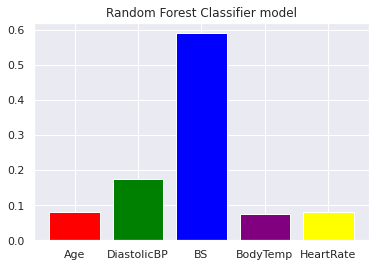

In [61]:
model = rfc.fit(data_changed)
sns.set(rc={'figure.figsize': (7,5)})
# plot feature importance
new_color = ['red', 'green', 'blue', 'purple', 'yellow', 'orange']
plt.bar(data_changed.columns[0:5], model.featureImportances, color=new_color)
plt.title('Random Forest Classifier model')

In [62]:
# concatenate the columns to calculate correlation coefficients
data_corr=data_changed.select(data_changed.columns[0:5] + [data_changed.columns[-3]]).toPandas()
# correlation
corr_mat=data_corr.corr()
# view the correlation values
corr_mat['RiskLevelIndex']

Age               0.263775
DiastolicBP       0.346536
BS                0.569161
BodyTemp          0.165693
HeartRate         0.188532
RiskLevelIndex    1.000000
Name: RiskLevelIndex, dtype: float64

In [63]:
from pyspark.ml import Pipeline
# prepare data and model
pipeline = Pipeline(stages=[rfc])
model = pipeline.fit(data_changed)

In [64]:
tree_model_classifier = model.stages[0]

In [65]:
print(tree_model_classifier.toDebugString)

RandomForestClassificationModel: uid=RandomForestClassifier_fce634339ee6, numTrees=20, numClasses=3, numFeatures=5
  Tree 0 (weight 1.0):
    If (feature 2 <= 7.95)
     If (feature 1 <= 97.5)
      If (feature 2 <= 7.055)
       If (feature 3 <= 99.5)
        If (feature 1 <= 49.5)
         Predict: 0.0
        Else (feature 1 > 49.5)
         Predict: 1.0
       Else (feature 3 > 99.5)
        If (feature 4 <= 67.5)
         Predict: 0.0
        Else (feature 4 > 67.5)
         Predict: 1.0
      Else (feature 2 > 7.055)
       If (feature 0 <= 14.5)
        If (feature 3 <= 98.2)
         Predict: 0.0
        Else (feature 3 > 98.2)
         Predict: 1.0
       Else (feature 0 > 14.5)
        Predict: 0.0
     Else (feature 1 > 97.5)
      If (feature 4 <= 62.5)
       Predict: 1.0
      Else (feature 4 > 62.5)
       Predict: 2.0
    Else (feature 2 > 7.95)
     If (feature 1 <= 87.0)
      If (feature 2 <= 9.5)
       If (feature 4 <= 72.5)
        If (feature 0 <= 17.5)
         

In [66]:
def parse_debug_string_lines(lines):
    
    block = []
    while lines:


        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block


def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    

    return json

In [67]:
import json

f_type_to_flist_dict = data_changed.schema['features'].metadata["ml_attr"]["attrs"]
f_index_to_name_dict = {}
for f_type, f_list in f_type_to_flist_dict.items():
   for f in f_list:
       f_index = f['idx']
       f_name = f['name']
       f_index_to_name_dict[f_index] = f_name

tree = tree_model_classifier.toDebugString
for i in range(len(f_index_to_name_dict)):
   tree = tree.replace('feature {}'.format(i), f_index_to_name_dict.get(i))

debug_str_to_json(tree)

{'name': 'Root',
 'children': [{'name': 'Tree 0 (weight 1.0):'},
  {'name': 'BS <= 7.95',
   'children': [{'name': 'DiastolicBP <= 97.5',
     'children': [{'name': 'BS <= 7.055',
       'children': [{'name': 'BodyTemp <= 99.5',
         'children': [{'name': 'DiastolicBP <= 49.5',
           'children': [{'name': 'Predict: 0.0'}]},
          {'name': 'DiastolicBP > 49.5',
           'children': [{'name': 'Predict: 1.0'}]}]},
        {'name': 'BodyTemp > 99.5',
         'children': [{'name': 'HeartRate <= 67.5',
           'children': [{'name': 'Predict: 0.0'}]},
          {'name': 'HeartRate > 67.5',
           'children': [{'name': 'Predict: 1.0'}]}]}]},
      {'name': 'BS > 7.055',
       'children': [{'name': 'Age <= 14.5',
         'children': [{'name': 'BodyTemp <= 98.2',
           'children': [{'name': 'Predict: 0.0'}]},
          {'name': 'BodyTemp > 98.2',
           'children': [{'name': 'Predict: 1.0'}]}]},
        {'name': 'Age > 14.5', 'children': [{'name': 'Predict: 0.0'

In [68]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 49.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 48.2 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=c16f372de77dc3265000f6de844a5be4103b0e8f049b4ddcbff2bb12d306743d
  Stored in directory: /home/ubuntu/.cache/pip/wheels/9b/13/01/6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


[Text(0.747327519806338, 0.9772727272727273, 'X[2] <= 7.95\nsquared_error = 0.65\nsamples = 1012\nvalue = 0.868'),
 Text(0.6224719410211268, 0.9318181818181818, 'X[1] <= 97.5\nsquared_error = 0.443\nsamples = 750\nvalue = 0.569'),
 Text(0.5072678257042254, 0.8863636363636364, 'X[3] <= 99.5\nsquared_error = 0.378\nsamples = 719\nvalue = 0.513'),
 Text(0.2937610035211268, 0.8409090909090909, 'X[2] <= 7.055\nsquared_error = 0.297\nsamples = 579\nvalue = 0.411'),
 Text(0.1012544014084507, 0.7954545454545454, 'X[0] <= 15.5\nsquared_error = 0.327\nsamples = 331\nvalue = 0.544'),
 Text(0.05070422535211268, 0.75, 'X[0] <= 13.5\nsquared_error = 0.205\nsamples = 52\nvalue = 0.288'),
 Text(0.028169014084507043, 0.7045454545454546, 'X[2] <= 6.85\nsquared_error = 0.227\nsamples = 20\nvalue = 0.65'),
 Text(0.011267605633802818, 0.6590909090909091, 'X[4] <= 73.5\nsquared_error = 0.083\nsamples = 11\nvalue = 0.909'),
 Text(0.005633802816901409, 0.6136363636363636, 'squared_error = 0.0\nsamples = 8\nva

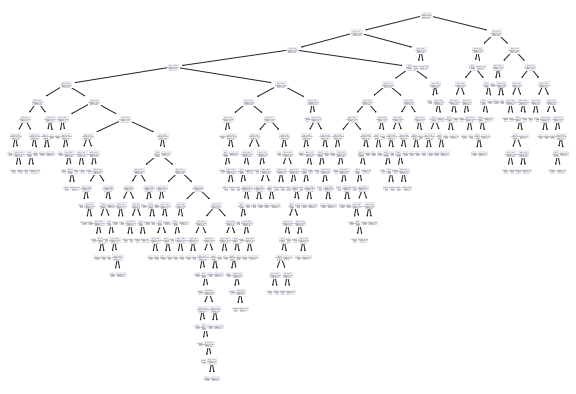

In [69]:
from sklearn import tree

# making sure that the columns are not already created
data_changed=data_changed.drop('RiskLevelIndex')
# convert stringtype to numerix
indexer = StringIndexer(inputCol="RiskLevel", outputCol="RiskLevelIndex")
indexer_fitted = indexer.fit(data_changed)
data_changed=indexer_fitted.transform(data_changed)
# collect class names
class_names=indexer_fitted.labels

features = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
target = 'RiskLevelIndex'

vector_assembler = VectorAssembler(inputCols=features, outputCol="features")

decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="RiskLevelIndex", seed=4)

dataset = data_changed.toPandas()[features+[target]]

# Regression tree on maternal data
fig = plt.figure(figsize=(10,7))
regr= tree.DecisionTreeRegressor() 
regr.fit(dataset[features], dataset[target])
tree.plot_tree(regr)

[Text(0.5, 0.875, 'X[2] <= 7.95\nsquared_error = 0.65\nsamples = 1012\nvalue = 0.868'),
 Text(0.25, 0.625, 'X[1] <= 97.5\nsquared_error = 0.443\nsamples = 750\nvalue = 0.569'),
 Text(0.125, 0.375, 'X[3] <= 99.5\nsquared_error = 0.378\nsamples = 719\nvalue = 0.513'),
 Text(0.0625, 0.125, 'squared_error = 0.297\nsamples = 579\nvalue = 0.411'),
 Text(0.1875, 0.125, 'squared_error = 0.489\nsamples = 140\nvalue = 0.936'),
 Text(0.375, 0.375, 'X[4] <= 63.0\nsquared_error = 0.177\nsamples = 31\nvalue = 1.871'),
 Text(0.3125, 0.125, 'squared_error = 0.222\nsamples = 3\nvalue = 0.667'),
 Text(0.4375, 0.125, 'squared_error = 0.0\nsamples = 28\nvalue = 2.0'),
 Text(0.75, 0.625, 'X[2] <= 9.5\nsquared_error = 0.262\nsamples = 262\nvalue = 1.721'),
 Text(0.625, 0.375, 'X[1] <= 95.0\nsquared_error = 0.386\nsamples = 53\nvalue = 1.377'),
 Text(0.5625, 0.125, 'squared_error = 0.379\nsamples = 47\nvalue = 1.298'),
 Text(0.6875, 0.125, 'squared_error = 0.0\nsamples = 6\nvalue = 2.0'),
 Text(0.875, 0.375,

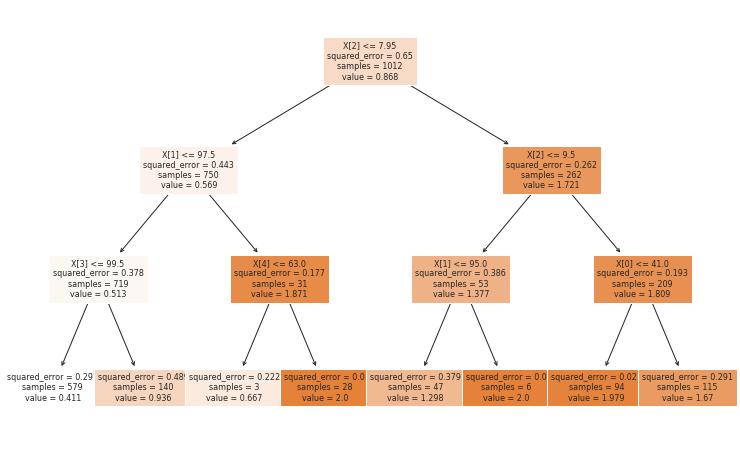

In [70]:
# Build a decision tree with max depth = 3
fig = plt.figure(figsize=(13,8))
regr= tree.DecisionTreeRegressor(max_depth=3) 
regr.fit(dataset[features], dataset[target])
tree.plot_tree(regr, filled = True, fontsize=8)

In [71]:
# model
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4)
model = rfc.fit(data_changed)
model.extractParamMap()

{Param(parent='RandomForestClassifier_8e40527e3d90', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_8e40527e3d90', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_8e40527e3d90', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_8e40527e3d90', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [72]:
df=model.extractParamMap()
schema=StructType(fields= [
        StructField('name', StringType(), True),
        StructField('doc', StringType(), True)
])
df=spark.createDataFrame(data=df, schema = schema).show(truncate=False)

+------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|name                    |doc                                                                                                                                                                                                                                                                                                                                                                                                                     

In [73]:
df=model.extractParamMap()
schema2=StructType(fields= [
    StructField("name", StructType([
        StructField('name', StringType(), True)
        ])),
    StructField("value", StringType(), True)
    ])
df=spark.createDataFrame(data=df.items(), schema = schema2).show(truncate=False)

+--------------------------+---------------+
|name                      |value          |
+--------------------------+---------------+
|{bootstrap}               |true           |
|{cacheNodeIds}            |false          |
|{checkpointInterval}      |10             |
|{featureSubsetStrategy}   |auto           |
|{featuresCol}             |features_scaled|
|{impurity}                |gini           |
|{labelCol}                |RiskLevelIndex |
|{leafCol}                 |               |
|{maxBins}                 |32             |
|{maxDepth}                |5              |
|{maxMemoryInMB}           |256            |
|{minInfoGain}             |0.0            |
|{minInstancesPerNode}     |1              |
|{minWeightFractionPerNode}|0.0            |
|{numTrees}                |20             |
|{predictionCol}           |prediction     |
|{probabilityCol}          |probability    |
|{rawPredictionCol}        |rawPrediction  |
|{seed}                    |4              |
|{subsampl

In [74]:
# library for evaluating performance
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [105]:
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
# fit model on train_data
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)

# Select (prediction, true label) and compute accuracy and test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))
# Confusion Matrix
print('\nConfusion Matrix \n', metrics.confusionMatrix().toArray())

Test Accuracy = 0.728889
Test Error = 0.271111

Confusion Matrix 
 [[66. 19.  1.]
 [25. 49.  4.]
 [ 6.  6. 49.]]


In [29]:
def testparams(**params):
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4, **params)
    model = rfc.fit(train_data)
    def model_score(evaluate_data):
        predictions=model.transform(evaluate_data)
        evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
        return evaluator.evaluate(predictions)
    return model_score(train_data), model_score(test_data)

In [30]:
np.around(testparams(numTrees=20), 4)

array([0.7471, 0.7289])

In [31]:
import warnings
warnings.simplefilter(action='ignore')

In [32]:
# visualize the number of trees in range (10, 1000) versus accuracy
numTrees = []
acc=[]
for i in range(10,1000, 10):
    acc.append(np.around(testparams(numTrees=i), 4))
    numTrees.append(i)

22/10/11 07:50:40 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/10/11 07:50:40 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/10/11 07:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1060.7 KiB
22/10/11 07:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1060.7 KiB
22/10/11 07:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB
22/10/11 07:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB
22/10/11 07:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1147.7 KiB
22/10/11 07:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1147.7 KiB
22/10/11 07:50:51 WARN DAGScheduler: Broadcasting large task binary with size 1182.6 KiB
22/10/11 07:50:51 WARN DAGScheduler: Broadcasting large task binary with size 1182.6 KiB
22/10/11 07:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
22/10/11 07:50:54 WAR

In [33]:
df = pd.DataFrame({'train_acc' : pd.Series(np.array(acc)[:,0]), 'test_acc': 
                   pd.Series(np.array(acc)[:,1]), 'numTrees' : 
                       pd.Series(numTrees)})
#find the trees with maximum test accuracy
df[df.test_acc == df['test_acc'].max()]

,train_acc,test_acc,numTrees
1,0.7471,0.7289,20


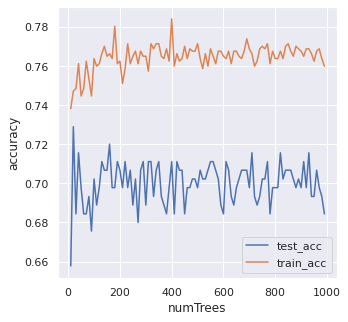

In [34]:
# visualizing training and testing errors
plt.subplots(figsize=(5,5))
plt.plot('numTrees', 'test_acc', data=df, label='test_acc')
plt.plot('numTrees', 'train_acc', data=df, label='train_acc')
plt.xlabel('numTrees')
plt.ylabel('accuracy')
plt.legend() 

In [35]:
# visualize train/test accuracy for the maxDepth in range (1,30) versus accuracy
maxDepth = []
acc = []
for i in range(1, 30):
    acc.append(np.around(testparams(numTrees=20, maxDepth=i), 4))
    maxDepth.append(i)

In [36]:
df = pd.DataFrame({'train_acc' : pd.Series(np.array(acc)[:,0]), 'test_acc' : 
                                           pd.Series(np.array(acc)[:,1]), 
                                                     'maxDepth' : pd.Series(maxDepth)})
df

,train_acc,test_acc,maxDepth
0,0.5909,0.5467,1
1,0.6150,0.5822,2
2,0.6722,0.6578,3
3,0.7014,0.6667,4
4,0.7471,0.7289,5
5,0.7942,0.7333,6
6,0.8221,0.7822,7
7,0.8539,0.7956,8
8,0.8691,0.7956,9
9,0.8958,0.8178,10


In [37]:
#find maxDepth of trees with maximum train accuracy <= 0.9
df[df.test_acc == df['test_acc'].max()]

,train_acc,test_acc,maxDepth
17,0.9238,0.8267,18


In [38]:
#find maxDepth of trees with maximum train accuracy <= 0.9
df[df.train_acc <= 0.9]

,train_acc,test_acc,maxDepth
0,0.5909,0.5467,1
1,0.6150,0.5822,2
2,0.6722,0.6578,3
3,0.7014,0.6667,4
4,0.7471,0.7289,5
5,0.7942,0.7333,6
6,0.8221,0.7822,7
7,0.8539,0.7956,8
8,0.8691,0.7956,9
9,0.8958,0.8178,10


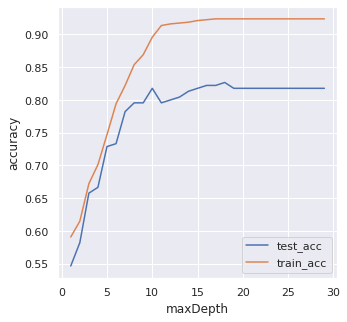

In [39]:
# visualizing changes in parameters 
plt.subplots(figsize = (5,5))
plt.plot('maxDepth', 'test_acc', data=df, label='test_acc')
plt.plot('maxDepth', 'train_acc', data=df, label='train_acc')
plt.xlabel('maxDepth')
plt.ylabel('accuracy')
plt.legend()

In [40]:
# find the best criterion 
acc=[]
minInstancesPerNode=[]
for i in range(1,10):
    tp = testparams(numTrees=20, maxDepth=10, minInstancesPerNode=i)
    acc.append(np.around(tp, 4))
    minInstancesPerNode.append(i)

In [41]:
df=pd.DataFrame({'train_acc' : pd.Series(np.array(acc)[:,0]), 
              'test_acc': pd.Series(np.array(acc)[:,1]), 
              'minInstancesPerNode': pd.Series(minInstancesPerNode)
             })

In [42]:
# view the results with train accuracy <=0.9
df[(df.train_acc>=0.75) & (df.train_acc<=0.9) & (df.test_acc>=0.8)]

,train_acc,test_acc,minInstancesPerNode
0,0.8958,0.8178,1
1,0.8780,0.8000,2


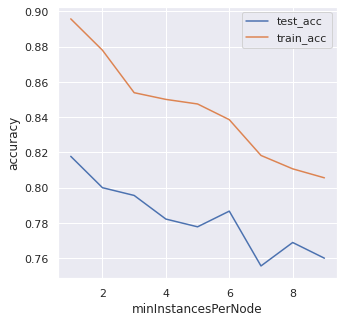

In [43]:
# visualizing training and testing errors
plt.subplots(figsize=(5,5))
plt.plot('minInstancesPerNode', 'test_acc', data=df, label='test_acc')
plt.plot('minInstancesPerNode', 'train_acc', data=df, label='train_acc')
plt.xlabel('minInstancesPerNode')
plt.ylabel('accuracy')
plt.legend()

In [44]:
maxBins = []
acc=[]
for i in range(3, 60):
    tp=testparams(numTrees=20, maxDepth=10, maxBins=i)
    acc.append(np.around(tp, 4))
    maxBins.append(i)

In [45]:
df = pd.DataFrame({'train_acc' : pd.Series(np.array(acc)[:,0]), 'test_acc': 
                   pd.Series(np.array(acc)[:,1]), 'maxBins' : pd.Series
                   (maxBins)})
# view the results with train accuracy <=0.9
df[(df.train_acc>=0.75) & (df.train_acc<=0.9) & (df.test_acc>=0.82)]

,train_acc,test_acc,maxBins
14,0.8869,0.8222,17
40,0.8818,0.8222,43
41,0.8818,0.8222,44
42,0.8818,0.8222,45
43,0.8818,0.8222,46
46,0.8844,0.8222,49
47,0.8844,0.8222,50
48,0.8844,0.8222,51
49,0.8844,0.8222,52
50,0.8844,0.8222,53


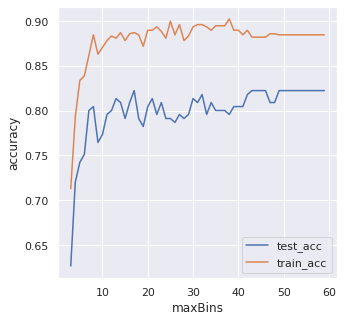

In [46]:
# visualizing training and testing errors
plt.subplots(figsize=(5,5))
plt.plot('maxBins', 'test_acc', data=df, label='test_acc')
plt.plot('maxBins', 'train_acc', data=df, label='train_acc')
plt.xlabel('maxBins')
plt.ylabel('accuracy')
plt.legend()

In [47]:
tp=testparams(numTrees=20, maxDepth=10, maxBins=17,
                      bootstrap=False)
np.around(tp, 4)

array([0.8983, 0.8133])

In [52]:
# optimal 'subsamplingRate'
subsamplingRate = []
acc=[]
for i in np.arange(0.8, 1, 0.01):
    tp=testparams(numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=i)
    acc.append(np.around(tp, 4))
    subsamplingRate.append(i)

In [53]:
df = pd.DataFrame({'train_acc' : pd.Series(np.array(acc)[:,0]), 'test_acc': 
                   pd.Series(np.array(acc)[:,1]), 'subsamplingRate' : pd.Series
                   (subsamplingRate)})
#find the trees with maximum test accuracy
df[df.test_acc >= 0.82] 

,train_acc,test_acc,subsamplingRate
4,0.8920,0.8267,0.84
14,0.8882,0.8356,0.94
17,0.8856,0.8356,0.97


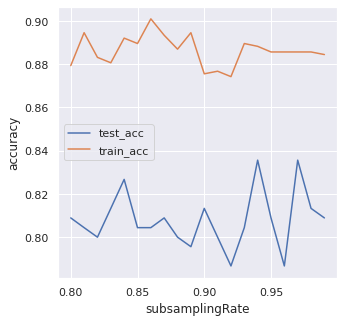

In [54]:
# visualizing training and testing errors
plt.subplots(figsize=(5,5))
plt.plot('subsamplingRate', 'test_acc', data=df, label='test_acc')
plt.plot('subsamplingRate', 'train_acc', data=df, label='train_acc')
plt.xlabel('subsamplingRate')
plt.ylabel('accuracy')
plt.legend()

Exception ignored in: <function JavaWrapper.__del__ at 0x7f95f9d99fc0>
Traceback (most recent call last):
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'


[Text(0.7039811643835616, 0.9545454545454546, 'X[2] <= 7.95\nsquared_error = 0.65\nsamples = 1012\nvalue = 0.868'),
 Text(0.5633561643835616, 0.8636363636363636, 'X[1] <= 97.5\nsquared_error = 0.443\nsamples = 750\nvalue = 0.569'),
 Text(0.449486301369863, 0.7727272727272727, 'X[3] <= 99.5\nsquared_error = 0.378\nsamples = 719\nvalue = 0.513'),
 Text(0.2422945205479452, 0.6818181818181818, 'X[2] <= 7.055\nsquared_error = 0.297\nsamples = 579\nvalue = 0.411'),
 Text(0.1113013698630137, 0.5909090909090909, 'X[0] <= 15.5\nsquared_error = 0.327\nsamples = 331\nvalue = 0.544'),
 Text(0.06164383561643835, 0.5, 'X[0] <= 13.5\nsquared_error = 0.205\nsamples = 52\nvalue = 0.288'),
 Text(0.03424657534246575, 0.4090909090909091, 'X[2] <= 6.85\nsquared_error = 0.227\nsamples = 20\nvalue = 0.65'),
 Text(0.0136986301369863, 0.3181818181818182, 'X[4] <= 73.5\nsquared_error = 0.083\nsamples = 11\nvalue = 0.909'),
 Text(0.00684931506849315, 0.22727272727272727, 'squared_error = 0.0\nsamples = 8\nvalue 

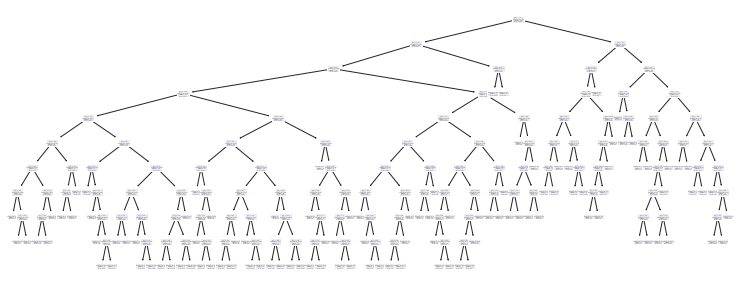

In [92]:
features = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
target = 'RiskLevelIndex'

dataset = data_changed.toPandas()[features+[target]]

# Regression tree on maternal data
fig = plt.figure(figsize=(13,5))
regr= tree.DecisionTreeRegressor(max_depth=10) 
regr.fit(dataset[features], dataset[target])
tree.plot_tree(regr)

In [93]:
# definition to evaluate train accuracy, test accuracy
def testparams(**params):
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4, **params)
    model = rfc.fit(train_data)
    def model_score(evaluate_data):
        predictions=model.transform(evaluate_data)
        evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
        return evaluator.evaluate(predictions)
    return model_score(train_data), model_score(test_data)

In [94]:
# train/test accuracy on tuned tree model
testparams(numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)

(0.8856416772554002, 0.8355555555555556)

In [95]:
# train/test accuracy on complete tree model
testparams()

(0.747141041931385, 0.7288888888888889)

In [99]:
# library for evaluating performance
from pyspark.mllib.evaluation import MulticlassMetrics
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
# fit model on train_data
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
# Confusion Matrix
print('Confusion Matrix \n', metrics.confusionMatrix().toArray())

Confusion Matrix 
 [[66. 19.  1.]
 [25. 49.  4.]
 [ 6.  6. 49.]]


In [101]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Evaluate model
rfcevaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")

params_grid = ParamGridBuilder().build()

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rfc,
                      estimatorParamMaps = params_grid,
                      evaluator = rfcevaluator,
                      numFolds = 10,
                     seed=1)
# Run cross validations.
rfcvModel = rfcv.fit(data_changed)

rfcvModel.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_6c1f5cb81512, numTrees=20, numClasses=3, numFeatures=5

In [86]:
!pip install pydotplus

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 KB 7.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=c0a58eb7a432f85019e0c3f859a2cba1bba6098f75ccc1397a965cb970ece008
  Stored in directory: /home/ubuntu/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus


In [87]:
import graphviz
import pydotplus
from sklearn.tree import export_graphviz

In [88]:
export_graphviz(regr,
                feature_names=features,
                filled=True,
                rounded=True)

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="BS <= 7.95\\nsquared_error = 0.65\\nsamples = 1012\\nvalue = 0.868", fillcolor="#f8dbc6"] ;\n1 [label="DiastolicBP <= 97.5\\nsquared_error = 0.443\\nsamples = 750\\nvalue = 0.569", fillcolor="#fcf2eb"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="BodyTemp <= 99.5\\nsquared_error = 0.378\\nsamples = 719\\nvalue = 0.513", fillcolor="#fdf7f2"] ;\n1 -> 2 ;\n3 [label="squared_error = 0.297\\nsamples = 579\\nvalue = 0.411", fillcolor="#ffffff"] ;\n2 -> 3 ;\n4 [label="squared_error = 0.489\\nsamples = 140\\nvalue = 0.936", fillcolor="#f6d5be"] ;\n2 -> 4 ;\n5 [label="HeartRate <= 63.0\\nsquared_error = 0.177\\nsamples = 31\\nvalue = 1.871", fillcolor="#e78b49"] ;\n1 -> 5 ;\n6 [label="squared_error = 0.222\\nsamples = 3\\nvalue = 0.667", fillcolor="#fbebdf"] ;\n5 -> 6 ;\n7 [label="squared_error = 0.0\\nsamples = 28\\nvalue = 2

In [112]:
from sklearn import tree
from pyspark.ml import Pipeline

features = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
target = 'RiskLevelIndex'
#drop features and recreate
data_changed=data_changed.drop('features')

vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="RiskLevelIndex", seed=4)
pipeline = Pipeline(stages=[vector_assembler, decision_tree])
model = pipeline.fit(data_changed)

# Regression tree on maternal data
fig = plt.figure(figsize=(10,7))
regr= tree.DecisionTreeRegressor() 
regr.fit(dataset[features], dataset[target])
#tree.plot_tree(regr)

DecisionTreeRegressor()

<Figure size 720x504 with 0 Axes>

[Text(0.5, 0.875, 'X[2] <= 7.95\nsquared_error = 0.65\nsamples = 1012\nvalue = 0.868'),
 Text(0.25, 0.625, 'X[1] <= 97.5\nsquared_error = 0.443\nsamples = 750\nvalue = 0.569'),
 Text(0.125, 0.375, 'X[3] <= 99.5\nsquared_error = 0.378\nsamples = 719\nvalue = 0.513'),
 Text(0.0625, 0.125, 'squared_error = 0.297\nsamples = 579\nvalue = 0.411'),
 Text(0.1875, 0.125, 'squared_error = 0.489\nsamples = 140\nvalue = 0.936'),
 Text(0.375, 0.375, 'X[4] <= 63.0\nsquared_error = 0.177\nsamples = 31\nvalue = 1.871'),
 Text(0.3125, 0.125, 'squared_error = 0.222\nsamples = 3\nvalue = 0.667'),
 Text(0.4375, 0.125, 'squared_error = 0.0\nsamples = 28\nvalue = 2.0'),
 Text(0.75, 0.625, 'X[2] <= 9.5\nsquared_error = 0.262\nsamples = 262\nvalue = 1.721'),
 Text(0.625, 0.375, 'X[1] <= 95.0\nsquared_error = 0.386\nsamples = 53\nvalue = 1.377'),
 Text(0.5625, 0.125, 'squared_error = 0.379\nsamples = 47\nvalue = 1.298'),
 Text(0.6875, 0.125, 'squared_error = 0.0\nsamples = 6\nvalue = 2.0'),
 Text(0.875, 0.375,

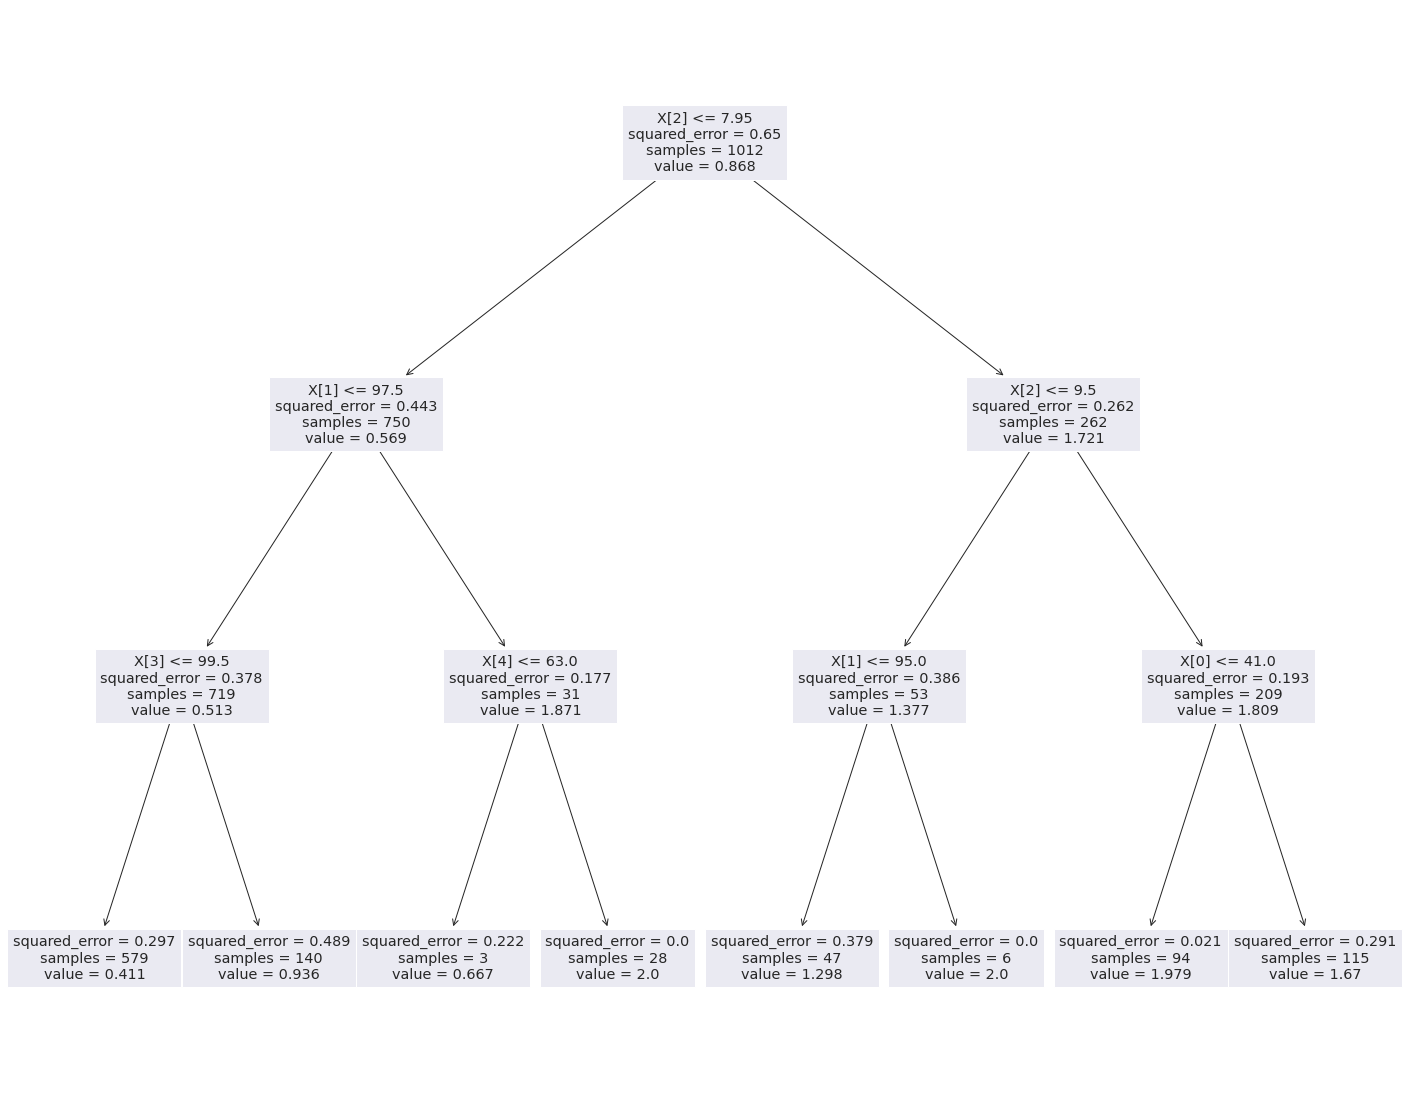

In [91]:
# Regression tree on maternal data

fig = plt.figure(figsize=(25,20))
regr= tree.DecisionTreeRegressor(max_depth=3)  
regr=regr.fit(dataset[features], dataset[target])
tree.plot_tree(regr) #, target_name='RiskLevel')
             #  feature_names=features,
             #  title="Maternal data set regression",
            #   fontname="Arial",
            #   colors = {"title":"purple"},
            #   scale=1.5

In [132]:
# calculate performance accuracy on all the features
data_changed=data.select(data.columns[0:8])
data_changed=data_changed.drop('SystolicBP') 
# collect the input features
assembler = VectorAssembler(
        inputCols=['Age','DiastolicBP','BS','BodyTemp','HeartRate'], outputCol="features")
# transform the data
data_changed=assembler.transform(data_changed)
# standardize the feature values
standardScaler=StandardScaler()
standardScaler.setInputCol('features')
model=standardScaler.fit(data_changed)
model.setOutputCol('features_scaled')
data_changed=model.transform(data_changed)

In [133]:
# library for evaluating performance
from pyspark.mllib.evaluation import MulticlassMetrics
# splitting data into training and test data set
train_data, test_data = data_changed.randomSplit(weights=[0.75,0.25], seed=1)
# definition to evaluate train accuracy, test accuracy
def testparams(**params):
    rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4, **params)
    model = rfc.fit(train_data)
    def model_score(evaluate_data):
        predictions=model.transform(evaluate_data)
        evaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")
        return evaluator.evaluate(predictions)
    return model_score(train_data), model_score(test_data)

In [135]:
# testparams print train error (left), test error (right)
print('train error (left), test error (right)\n', testparams(numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97))
# fit model on train_data
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)
model = rfc.fit(train_data)
# predict response
predictions = model.transform(test_data)
# Metrics
predictionRDD = predictions.select(['RiskLevelIndex', 'prediction']).rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
# Confusion Matrix
print('\n Confusion Matrix \n', metrics.confusionMatrix().toArray())

train error (left), test error (right)
 (0.8856416772554002, 0.8355555555555556)

 Confusion Matrix 
 [[71. 14.  1.]
 [13. 62.  3.]
 [ 1.  5. 55.]]


In [140]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import *

In [141]:
# rfc model
rfc = RandomForestClassifier(labelCol='RiskLevelIndex',featuresCol='features_scaled', seed=4,
                            numTrees=20, maxDepth=10, maxBins=17, subsamplingRate=0.97)

# Evaluate model
rfcevaluator = MulticlassClassificationEvaluator(
            labelCol="RiskLevelIndex", predictionCol="prediction", metricName="accuracy")

params_grid = ParamGridBuilder().build()

# create 10-fold cross validator with 10 repeats
accuracy=[]
for i in range(0,10):
    # shuffle data
    shuffledDF = data_changed.orderBy(rand())
    # split data into train and test data set
    train_data, test_data = shuffledDF.randomSplit(weights=[0.75,0.25], seed=1)
    # 10-fold CrossValidator
    rfcv = CrossValidator(estimator=rfc, estimatorParamMaps=params_grid, evaluator=rfcevaluator, numFolds=10, seed=1)
    # run cross validations
    cvmodel = rfcv.fit(train_data)
    # model predictions
    predictions = cvmodel.transform(test_data)
    accuracy.append(evaluator.evaluate(predictions))
np.average(accuracy)

0.8355555555555556